In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
#export

from random import random
import os
import torch
import numpy as np
from torch.utils.data import Dataset
import glob
import cv2
from matplotlib import pyplot as plt
from torchvision import transforms
import torch.nn as nn
from ml_package.dataload.human_ds import SimplePeopleSegmentationDS
import torch.nn.functional as F


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


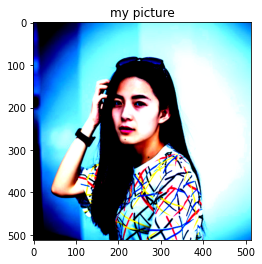

In [16]:
ds = SimplePeopleSegmentationDS("../datasets/Human-Segmentation-Dataset/Training_Images",
                                "../datasets/Human-Segmentation-Dataset/Ground_Truth")

dataset_loader = torch.utils.data.DataLoader(ds,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

img_show = ds[0]['image'].numpy().transpose((1,2,0))
plt.imshow(img_show)
plt.title('my picture')
plt.show()

In [18]:
#export
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [19]:
model = UNet(n_channels=3, n_classes=1).float()
model.cuda()
model

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

In [20]:
#export
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1.,
                           eps=self.eps, threshold=None,
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = BCEDiceLoss(eps=1.0, activation=None)


In [22]:
n_epochs = 1
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    model.train()
    for sample in dataset_loader:
        data, target = sample['image'], sample['segmentation']
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
train_loss

332.8752930164337

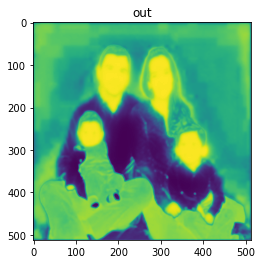

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


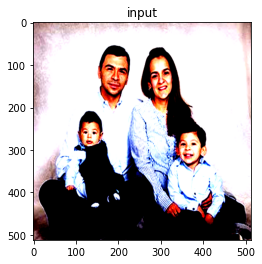

In [23]:
input = ds[15]['image']
model.eval()
output = model(input.unsqueeze(0).cuda())
output = output.squeeze(0)
output = output.cpu().detach().numpy().transpose((1,2,0))
plt.imshow(output)
plt.title('out')
plt.show()
plt.imshow(input.numpy().transpose((1,2,0)))
plt.title('input')
plt.show()


In [24]:
from nbdev import *
%nbdev_default_export unet.model
from nbdev.export import *
notebook2script()


Cells will be exported to ml_package.unet.model,
unless a different module is specified after an export flag: `%nbdev_export special.module`
Converted datasets.ipynb.
Converted testing.ipynb.
